In [24]:
from utils import * 
import os 
from src.ggkbase import * 
import glob
import matplotlib as mpl 
from src.files import BLASTFileJSON, FASTAFile, InterProScanFileTSV, GenBankFile, fasta_get_genome_size
import subprocess
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap, to_hex
from src.metat import metat_load 

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
coverm_df = coverm_load('../data/coverm/all.tsv', contig_sizes=contig_sizes)
coverm_df = coverm_df[coverm_df.sample_id.str.contains('n_|ck_', regex=True)].copy()
metat_df = metat_load()
bbduk_df = bbduk_load('../data/bbduk')

In [25]:
cmap_blues = LinearSegmentedColormap.from_list('blues', ['lightblue', 'steelblue'])
cmap_grays = LinearSegmentedColormap.from_list('grays', ['lightgray', 'gray'])

def cmap_sample(cmap, n):
    return [to_hex(color) for color in cmap(np.linspace(0, 1, n))]

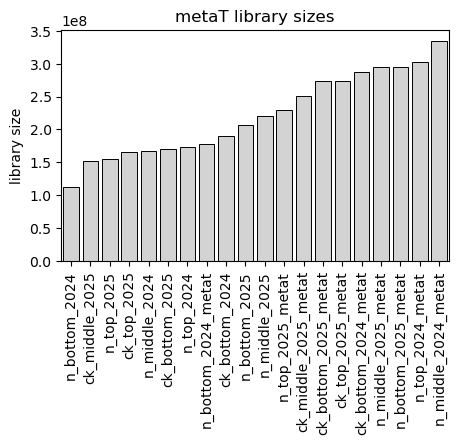

In [ ]:

fig, ax = plt.subplots(figsize=(5, 3))
figure_df =  bbduk_df[bbduk_df.index.str.contains('ck_|n_')].copy() # Bioreactor samples only.
figure_df = figure_df.reset_index(drop=False) 
figure_df = figure_df.sort_values('library_size')
sns.barplot(figure_df, y='library_size', x='sample_id', color='lightgray', edgecolor='black', lw=0.7) #, hue='library_size', palette='Grays', legend=False)
ax.set_xlabel('')
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
ax.set_ylabel('library size')
ax.set_title('metaT library sizes')
plt.show()
# for row in bbduk_df[bbduk_df.index.str.contains('ck_|n_')].itertuples():
#     print(row.Index, row.library_size)

# Library sizes range from around 150,000,000 to 350,000,000. Probably want to be more lenient than not, so select a CPM
# which could correspond to a count of ~5 for 1e8, or (5 / (1e8 / 1e6))

In [47]:

def remove_low_abundance_genomes(coverm_df, min_rpkm:float=1, min_n_samples:int=1):
    include_genome_ids = coverm_df.groupby('genome_id').apply(lambda df : (df.rpkm > min_rpkm).sum() > min_n_samples, include_groups=False)
    include_genome_ids = include_genome_ids[include_genome_ids].index 
    n_genome_ids = coverm_df.genome_id.nunique()
    print(f'remove_low_abundance_genomes: Retaining {len(include_genome_ids)} out of {n_genome_ids} targets after filtering for abundance.')
    return coverm_df[coverm_df.genome_id.isin(include_genome_ids)].copy()


def plot_abundance(figure_df:pd.DataFrame, title=r'$\it{Methanoperedens}$ abundance', min_rpkm=1e-2, legend:bool=True, ax=None):

    figure_df = figure_df.sort_values(['sample_id', 'genome_id'], ascending=True)
    # figure_df = figure_df.copy()
    figure_df['year'] = [re.search(r'202\d', sample_id).group(0) for sample_id in figure_df.sample_id]
    figure_df = remove_low_abundance_genomes(figure_df, min_rpkm=min_rpkm).copy()
    
    sample_ids = figure_df.sample_id.unique()
    n_samples = figure_df.sample_id.nunique()

    genome_ids = sorted(figure_df.genome_id.unique())
    palettes = dict()
    palettes['2024'] = dict(zip(genome_ids, cmap_sample(cmap_grays, len(genome_ids))))
    palettes['2025'] = dict(zip(genome_ids, cmap_sample(cmap_blues, len(genome_ids))))
    # print(palettes)

    bottom = np.zeros(n_samples)
    for genome_id, df in figure_df.groupby('genome_id'):
        colors = [palettes[year].get(genome_id, 'red') for year in df.year]
        heights = df.set_index('sample_id').rpkm.to_dict() # Make this robust to when some samples aren't present. 
        heights = np.array([heights.get(sample_id, 0) for sample_id in sample_ids])
        ax.bar(x=np.arange(n_samples), height=heights, bottom=bottom, label=genome_id, edgecolor='black', lw=0.7, color=colors)
        bottom += heights
    ax.set_title(title)
    ax.set_ylabel('RPKM')
    ax.set_xticks(np.arange(n_samples), labels=[sample_id.replace('_metat', '') for sample_id in sample_ids], rotation=90)

    if legend:
        handles = [Patch(edgecolor='black', linewidth=0.7, facecolor=palettes['2025'][genome_id]) for genome_id in genome_ids]
        ax.legend(handles, genome_ids)


remove_low_abundance_genomes: Retaining 5 out of 5 targets after filtering for abundance.
remove_low_abundance_genomes: Retaining 4 out of 25 targets after filtering for abundance.


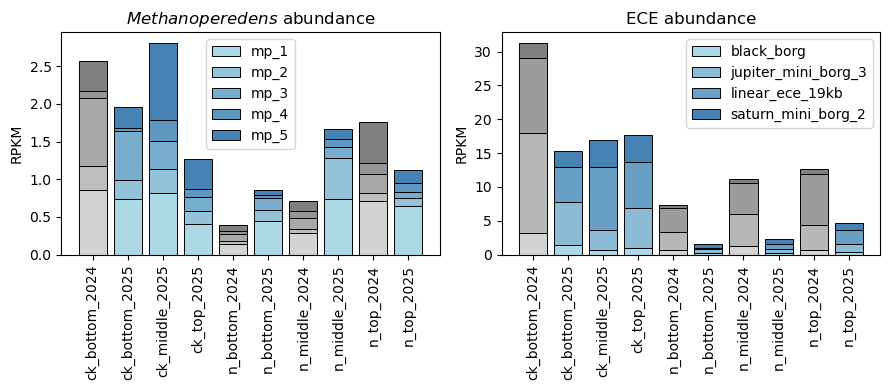

In [48]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(9, 4), ncols=2)

plot_abundance(coverm_df[is_mp(coverm_df)].copy(), ax=ax_a, title=r'$\it{Methanoperedens}$ abundance', min_rpkm=1e-2)
plot_abundance(coverm_df[~is_mp(coverm_df)].copy(), ax=ax_b, title='ECE abundance', min_rpkm=1)

fig.tight_layout()
plt.show()

remove_low_abundance_genomes: Retaining 5 out of 5 targets after filtering for abundance.
remove_low_abundance_genomes: Retaining 4 out of 25 targets after filtering for abundance.


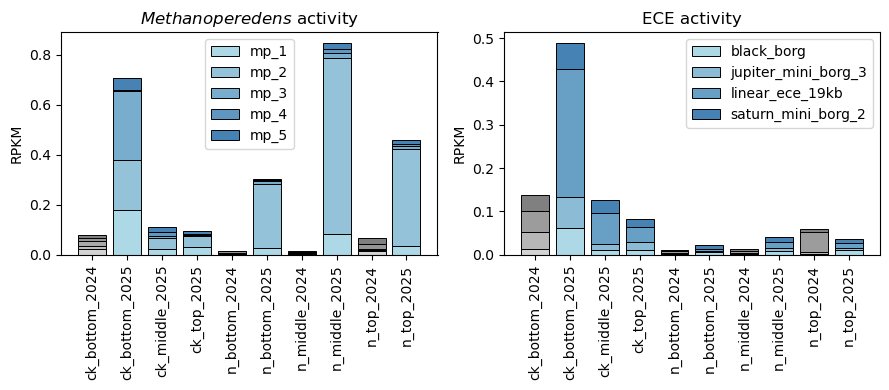

In [49]:
fig, (ax_a, ax_b) = plt.subplots(figsize=(9, 4), ncols=2)

figure_df = metat_df.groupby(['genome_id', 'sample_id']).agg({'read_count':'sum', 'length':'sum', 'library_size':'first'}).reset_index()
figure_df['rpkm'] = figure_df.read_count / (figure_df.length / 1e3) / (figure_df.library_size / 1e6)

plot_abundance(figure_df[is_mp(figure_df)], ax=ax_a, title=r'$\it{Methanoperedens}$ activity', min_rpkm=1e-2)
plot_abundance(figure_df[~is_mp(figure_df)], ax=ax_b, title='ECE activity', min_rpkm=1e-2)

fig.tight_layout()
plt.show()

In [ ]:
# Because the data is compositional, it is possible that what appears to be a decrease in ECE activity could be due to the increase in activity of
# the other Methanoperedens which does not host ECEs (mp_2)